# Imports, initializations

In [1]:
import POIO as po
import numpy as np
from matplotlib import pyplot as plt
# %matplotlib agg
import matplotlib.gridspec as gridspec
from astro import constants as c
import healpy as hp
from astropy.convolution import convolve, Gaussian1DKernel
import matplotlib as mpl
plt.rcParams.update({'figure.max_open_warning': 0})

#### User section ###########
noutput = 1                            # In case there are several rascas runs for the same spectrum,  
#the codes add them together
line = 1302.168                        # Wavelength of the line, in Angstrom
v_plot = True                          # X-axis is km/s if true,  otherwise Angstroms
normalized = True                      # Y-axis is normalized if true,  otherwise in erg/s
dark = False                           # Dark background for the plots
color = 'g'                            # Color of the spectrum
fig_size = [12, 16]
FWHM = [10, 20, 30]                    # Full width at half maximum 
#of the gaussian with which the line is convoluted,  in km/s
#############################

In [2]:
#For practical reasons
x = np.repeat(range(4),3)
y = np.tile(range(3),4)
z = np.repeat(range(3),4)

#This is to reproduce the 108 directions that I used in the peeling-off
nside = 3  #nDirections = 12 * nside^2
nvec = hp.nside2npix(nside)
k = [[0]*3]*nvec
for i in range (0,nvec) :
    k[i] = hp.pix2vec(nside,i)

# Computation of the velocity of the center of mass of the stars

In [5]:
# import minirats 
from minirats.HaloFinder.py.haloCatalog import haloCatalog as hC
from minirats.utils.py.cellutils import py_cell_utils as cu
from minirats.utils.py.f90utils import star_utils as SU

RamsesDir = '/cral2/sphinx/05_F1000/02_IC20_BP/'
timestep = 183
hcat = hC(RamsesDir,timestep,HaloDir='Halos/',zoom=True)
hcat.info;

In [6]:
center = [0.60334516, 0.22293025, 0.1404317]
radius = 0.0112

In [5]:
nstars = SU.get_tot_nstars(RamsesDir,timestep)   # get nb of star particles in the output
star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,star_mets,star_minit = SU.read_stars_all_props(RamsesDir,timestep,nstars,True,age_conv=True)

In [6]:
print(nstars)

11408322


In [7]:
# select star particles in the halo 
d2 = (star_x-center[0])**2 + (star_y-center[1])**2 + (star_z-center[2])**2
ii = np.where(d2 < radius*radius)[0]
star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,star_mets,star_minit = \
    star_mass[ii],star_x[ii],star_y[ii],star_z[ii],star_id[ii],star_age[ii],star_vx[ii],\
    star_vy[ii],star_vz[ii],star_mets[ii],star_minit[ii]

In [8]:
print(star_mass.size)

1510247


In [9]:
v_cm_x = sum(star_mass*star_vx)/sum(star_mass)*hcat.info["unit_v"]/1e5  #Velocity of CM, in km/s
v_cm_y = sum(star_mass*star_vy)/sum(star_mass)*hcat.info["unit_v"]/1e5
v_cm_z = sum(star_mass*star_vz)/sum(star_mass)*hcat.info["unit_v"]/1e5
v_cm = np.array([v_cm_x, v_cm_y, v_cm_z])

print(v_cm)
#Save v_cm for Halo1 : [-20.46598285   6.97327095  20.72443485]

[-20.46598285   6.97327095  20.72443485]


In [3]:
v_cm = [-20.46598285, 6.97327095, 20.72443485]

# Plots

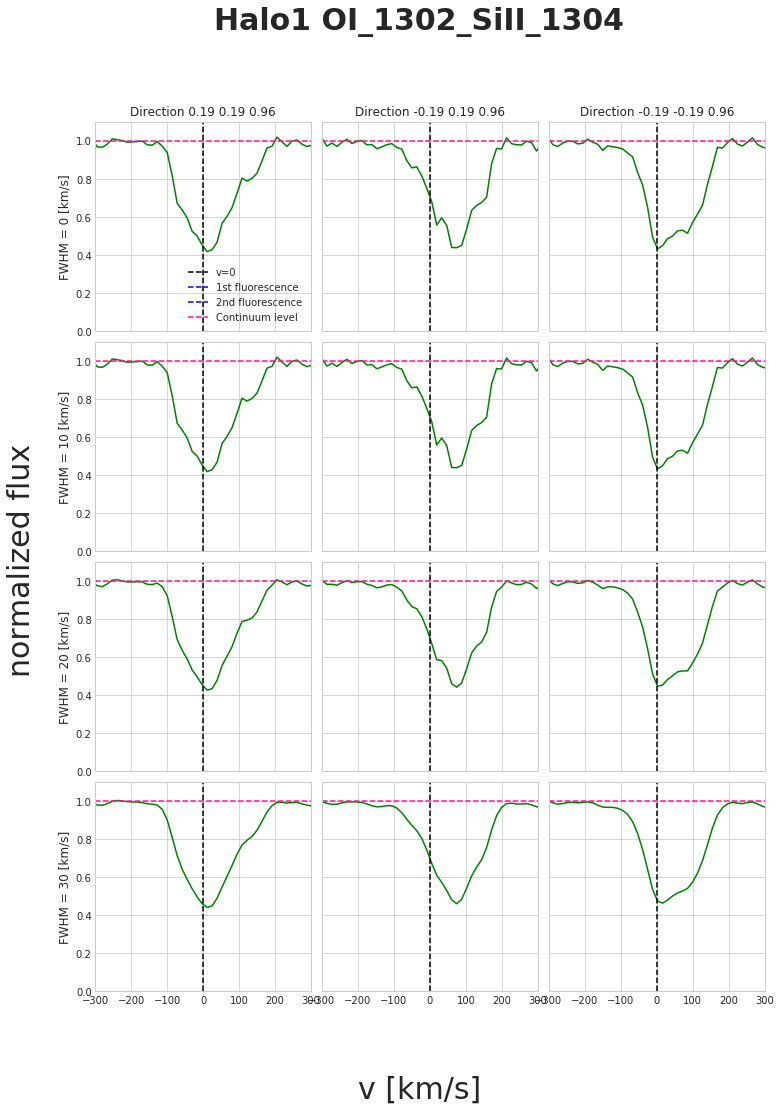

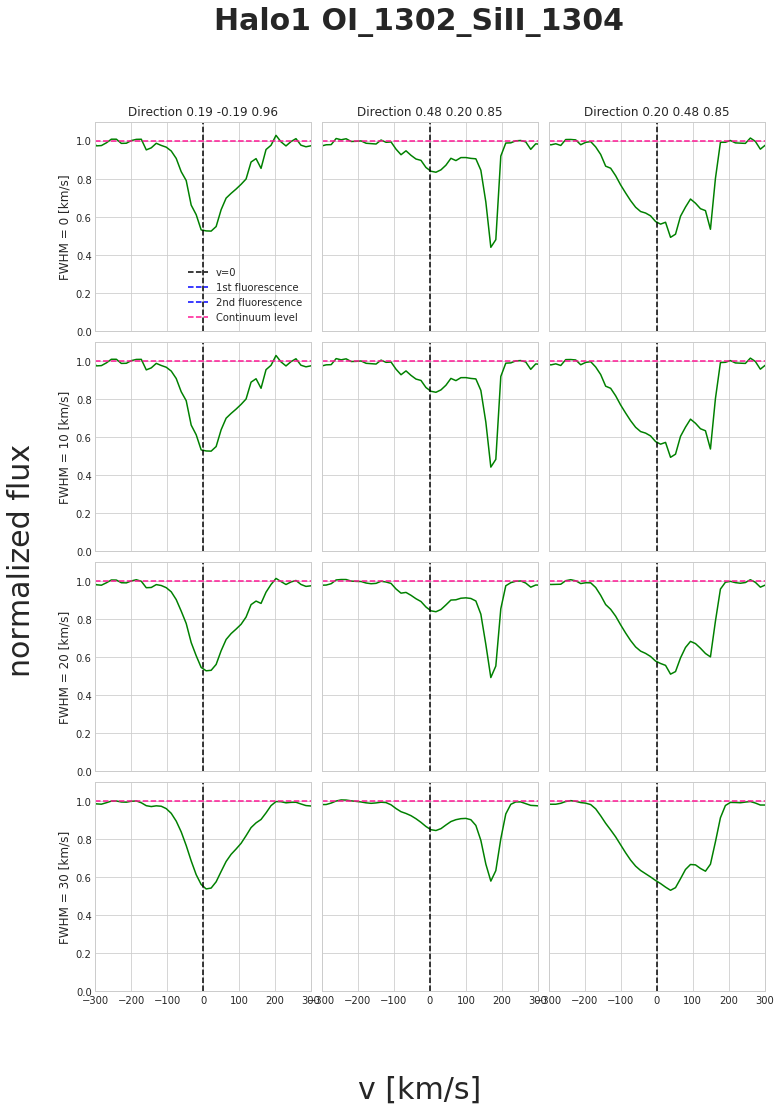

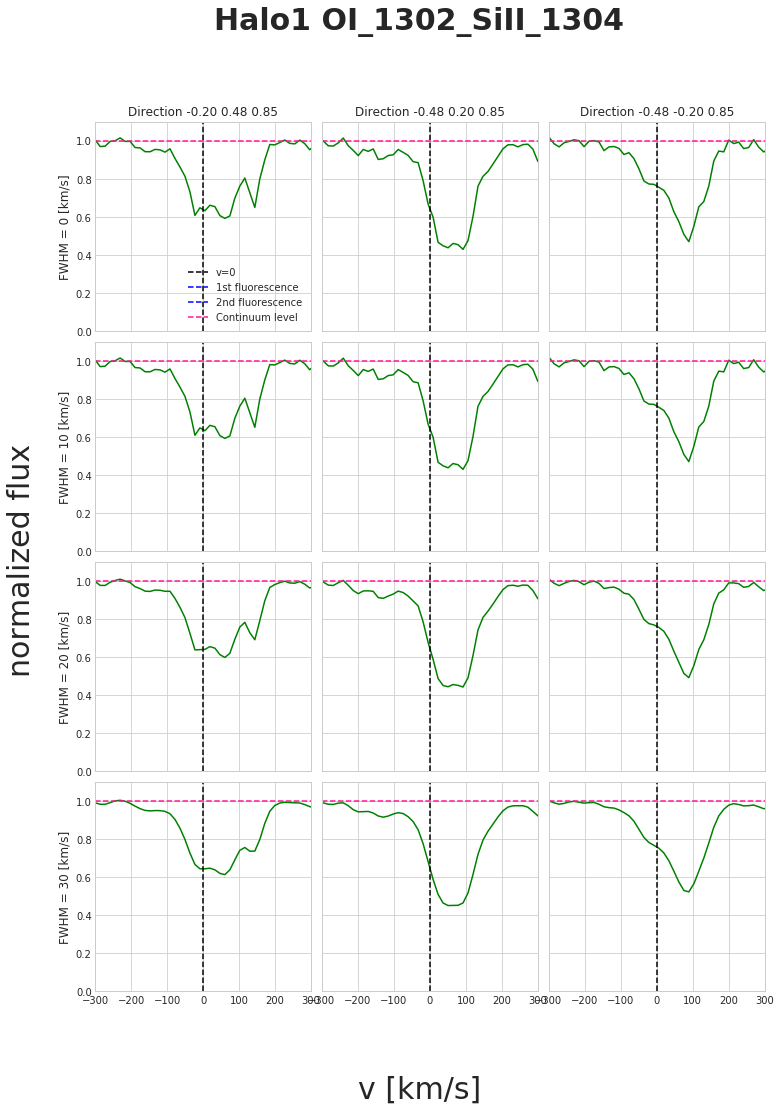

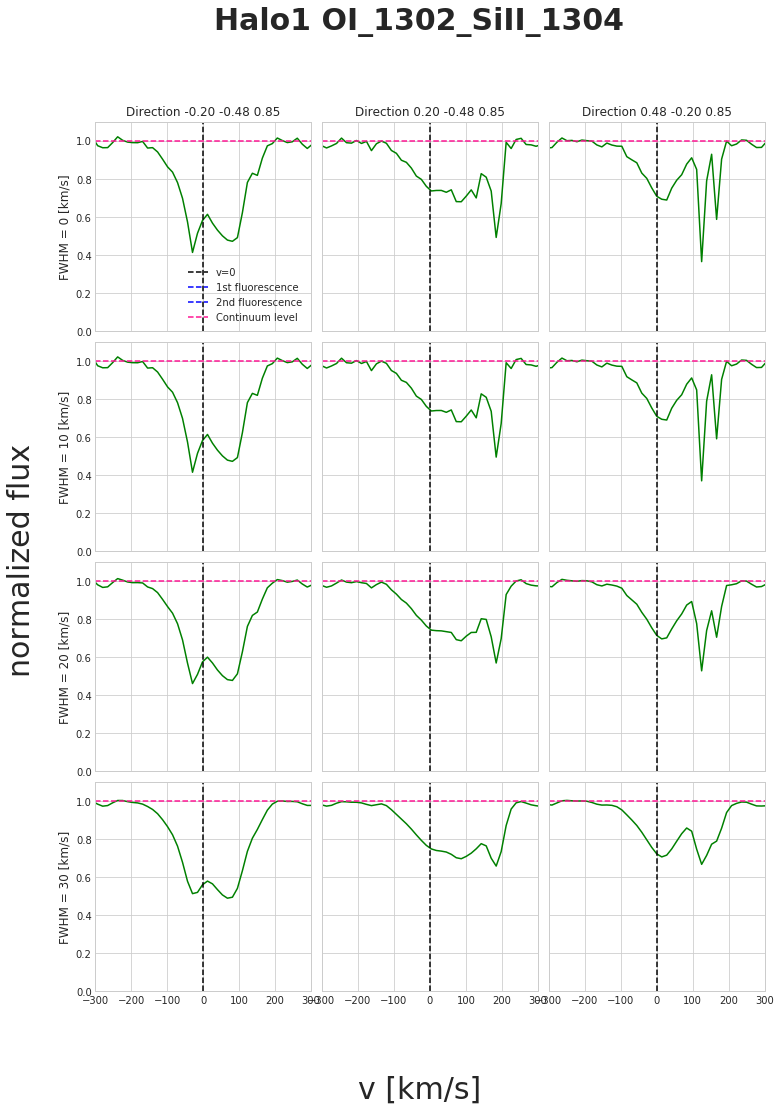

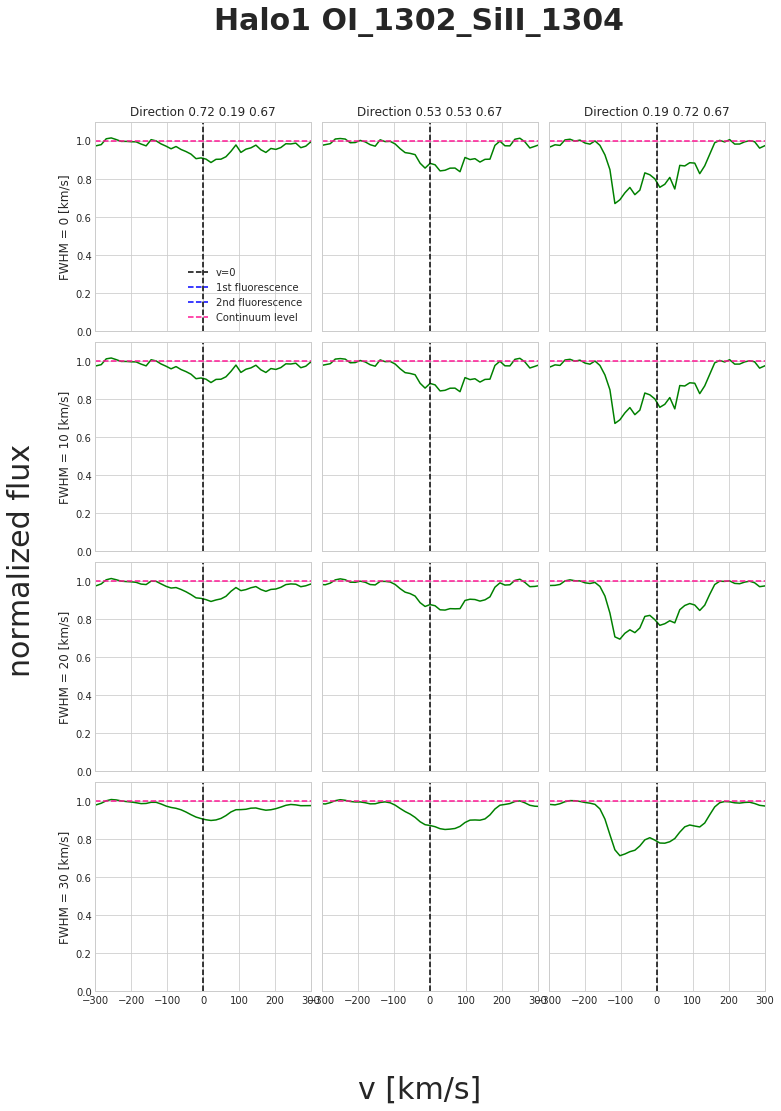

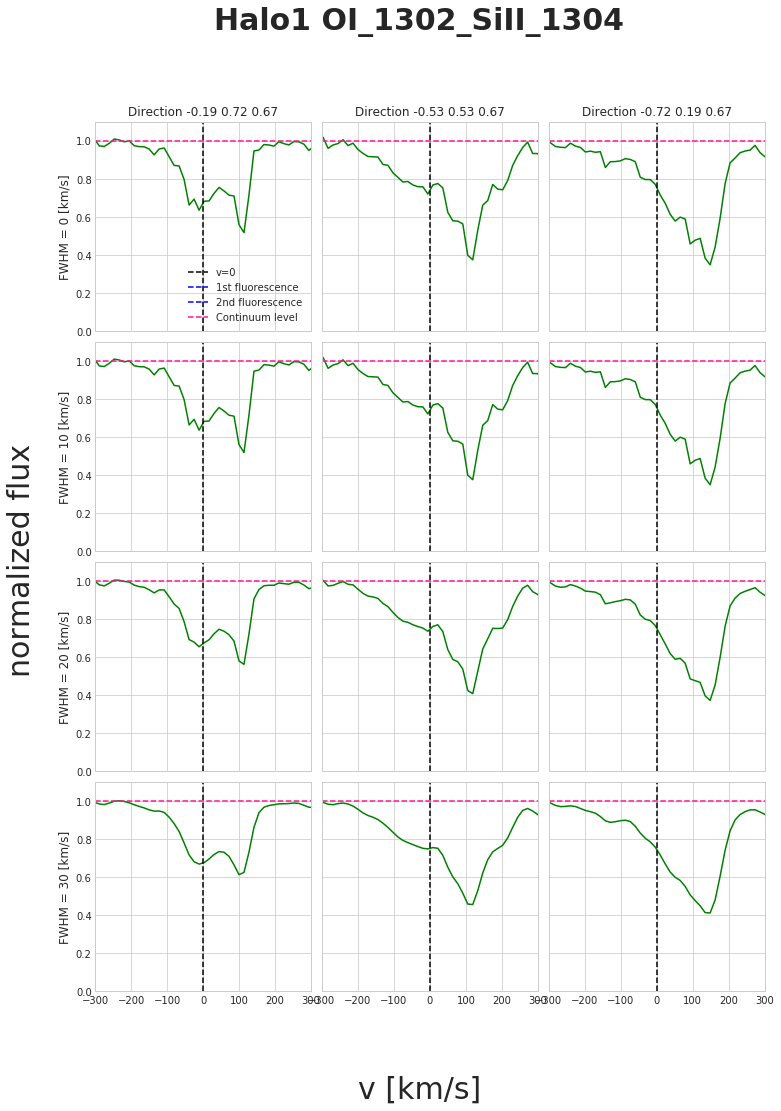

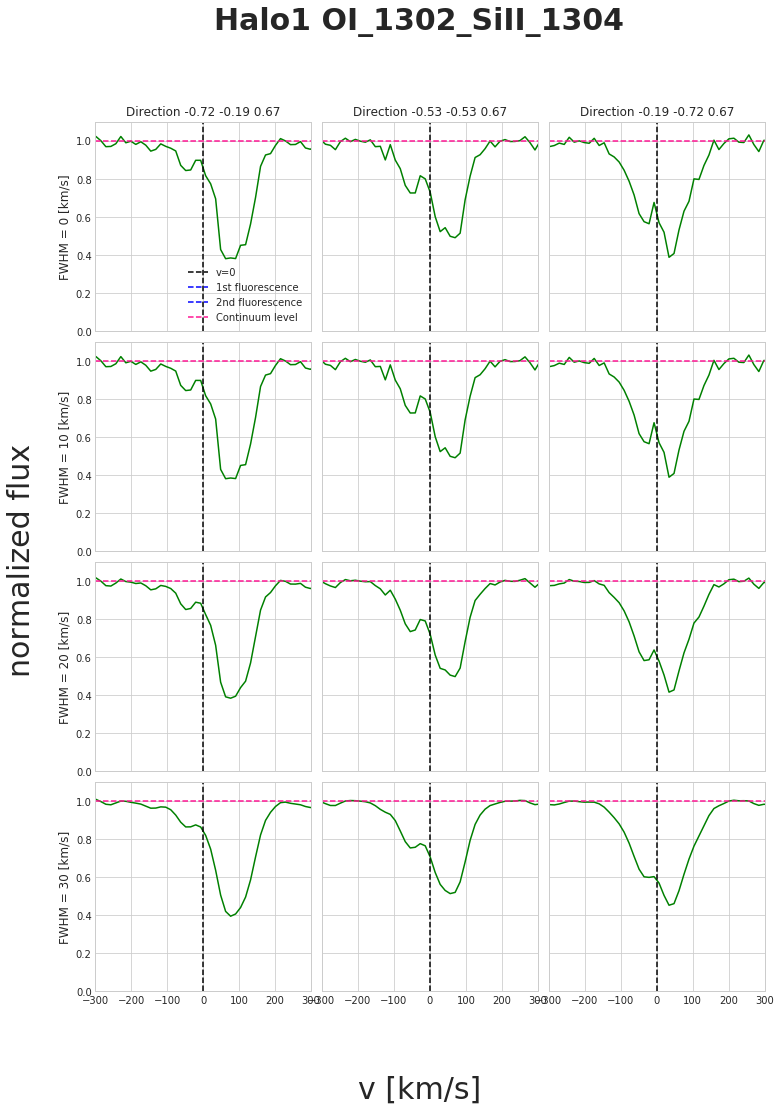

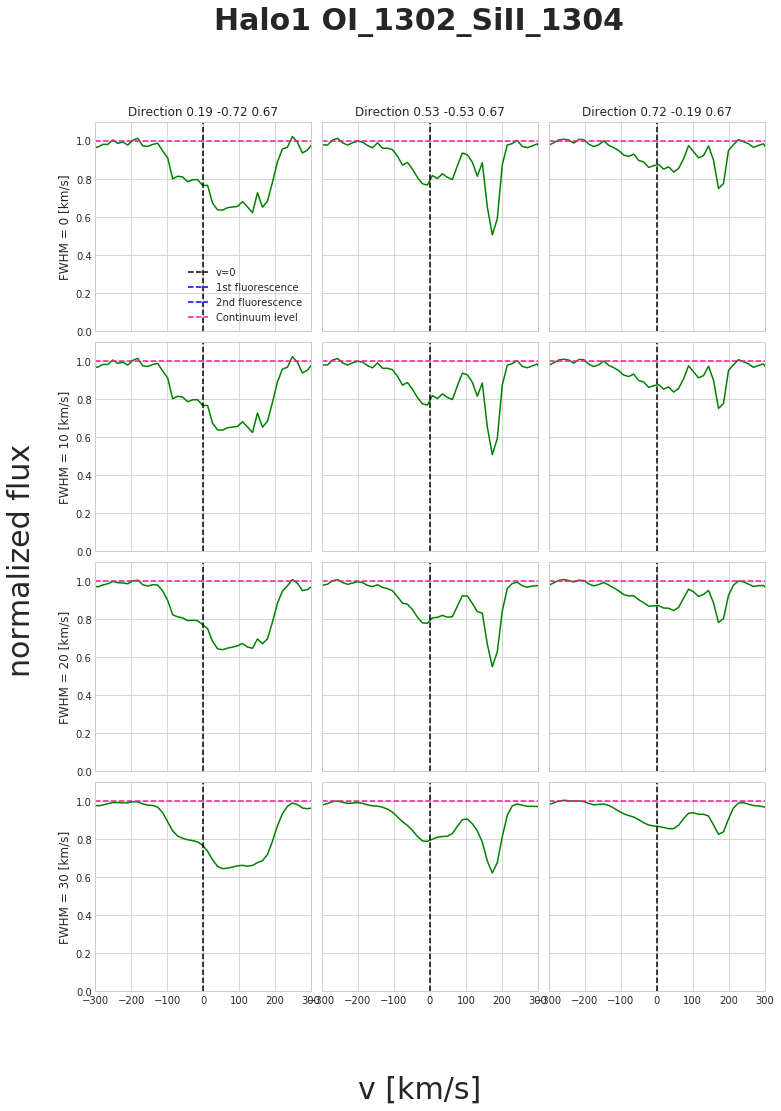

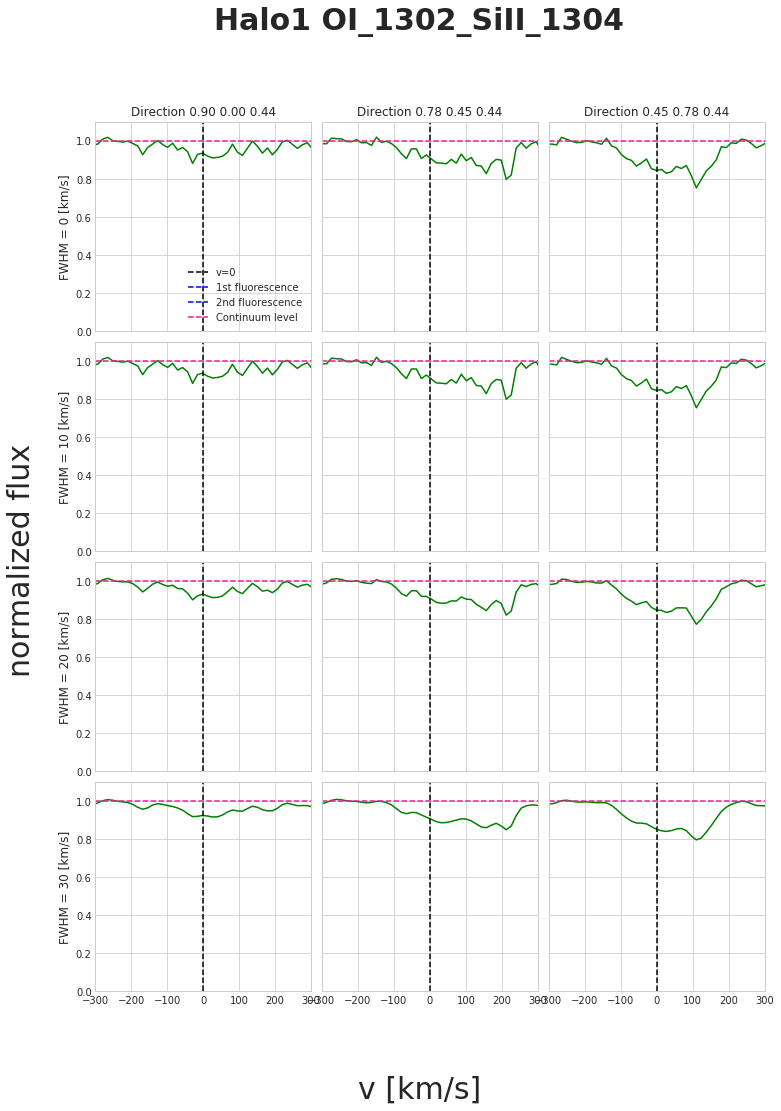

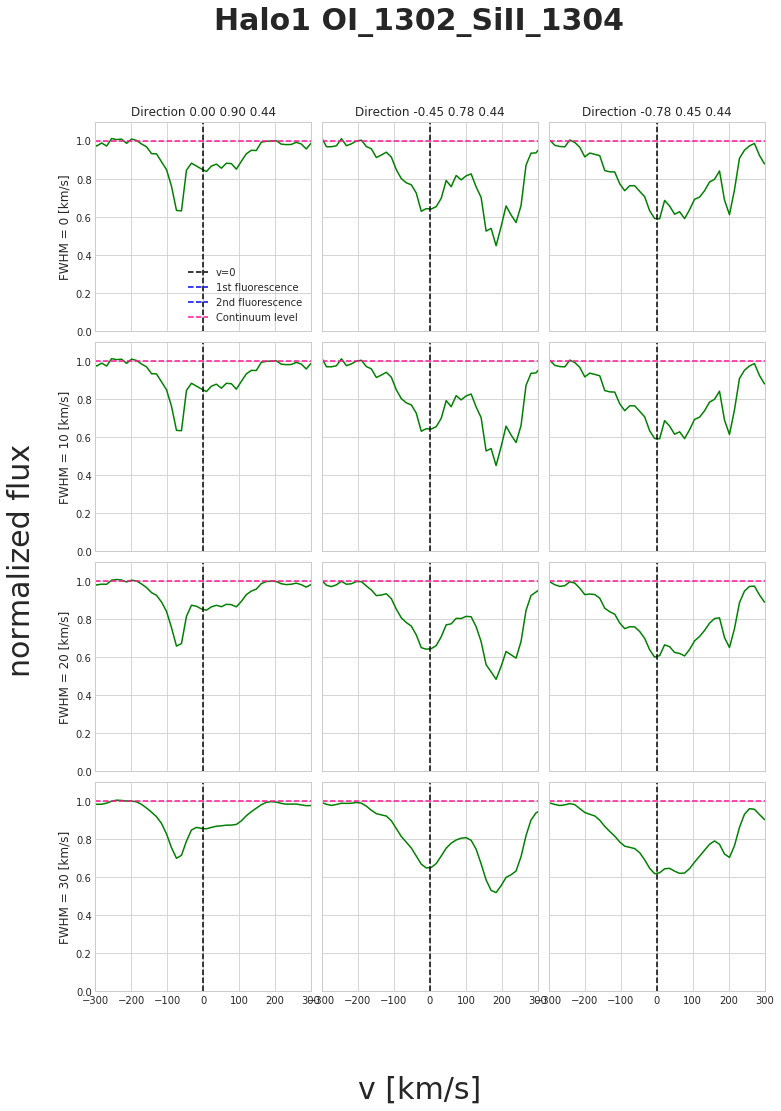

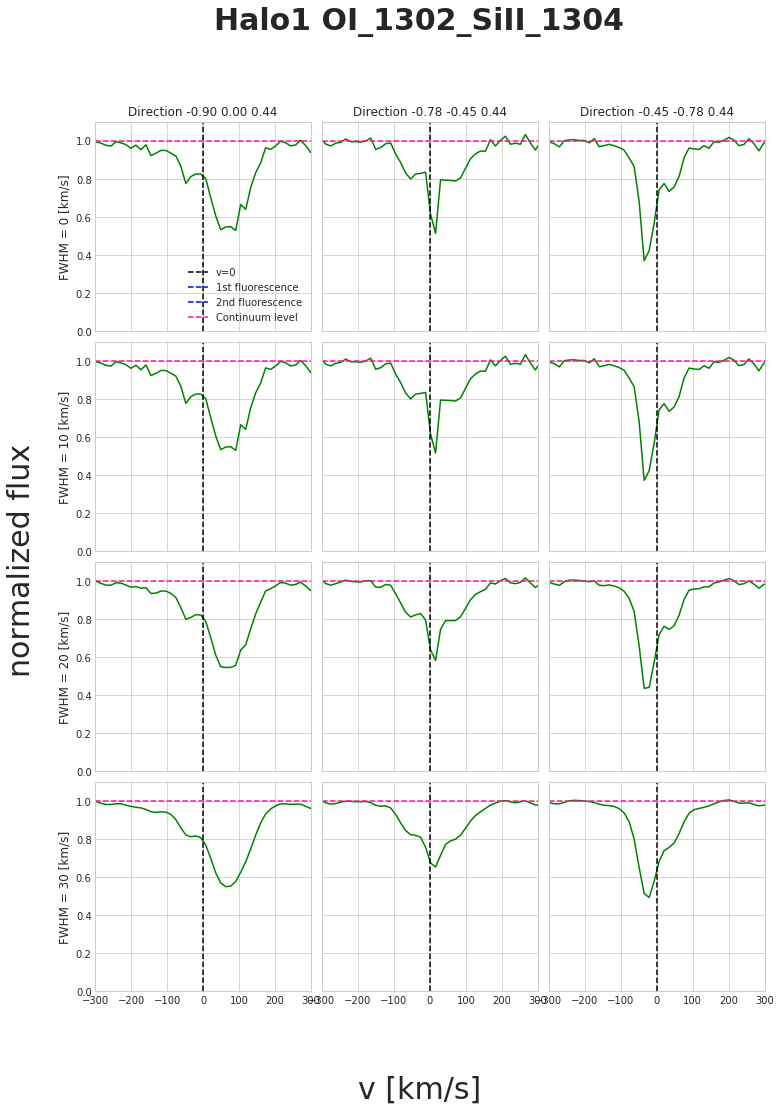

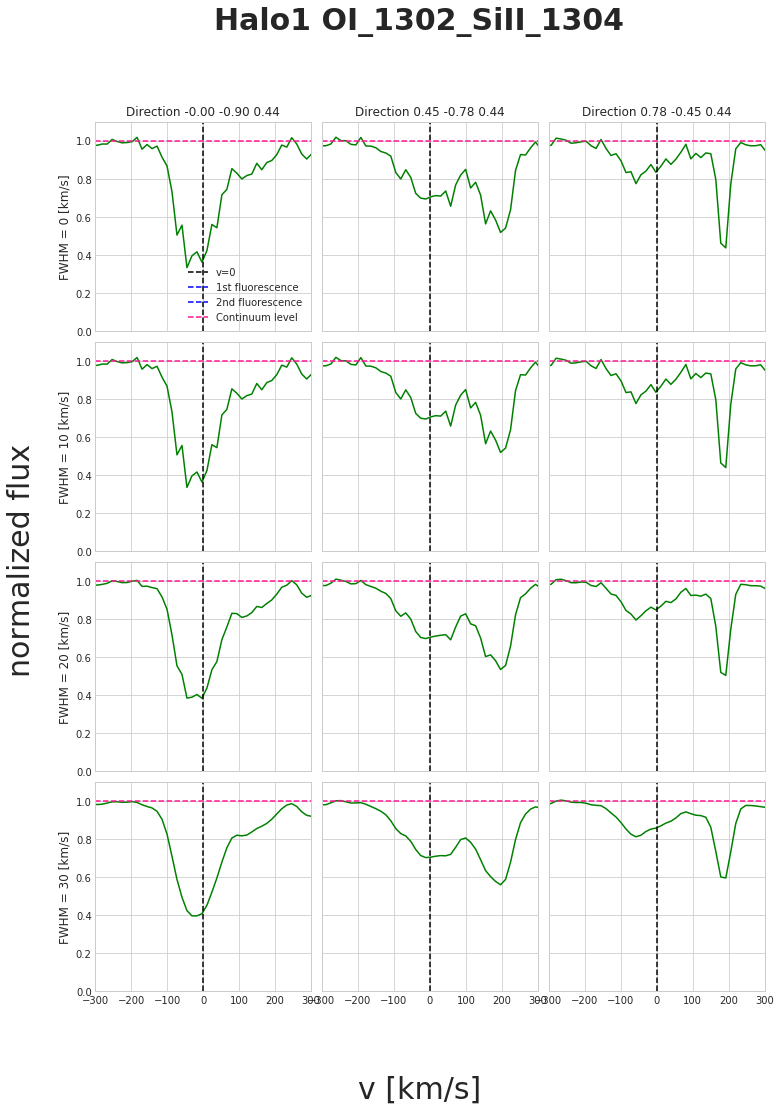

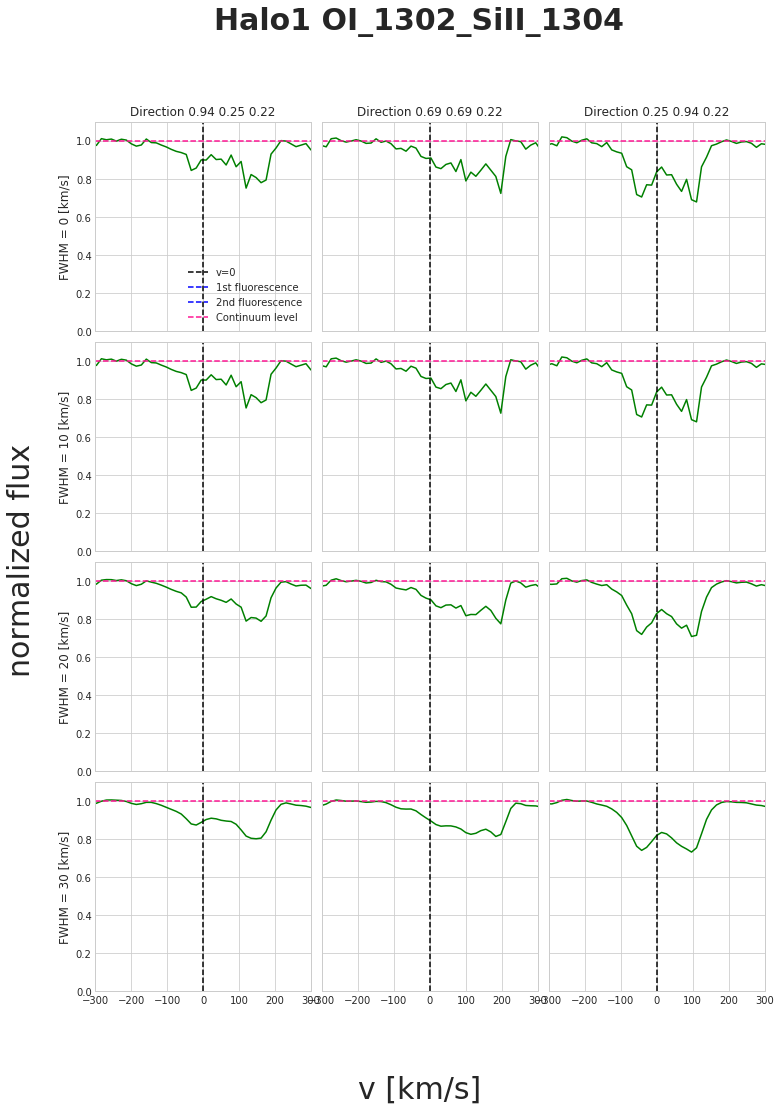

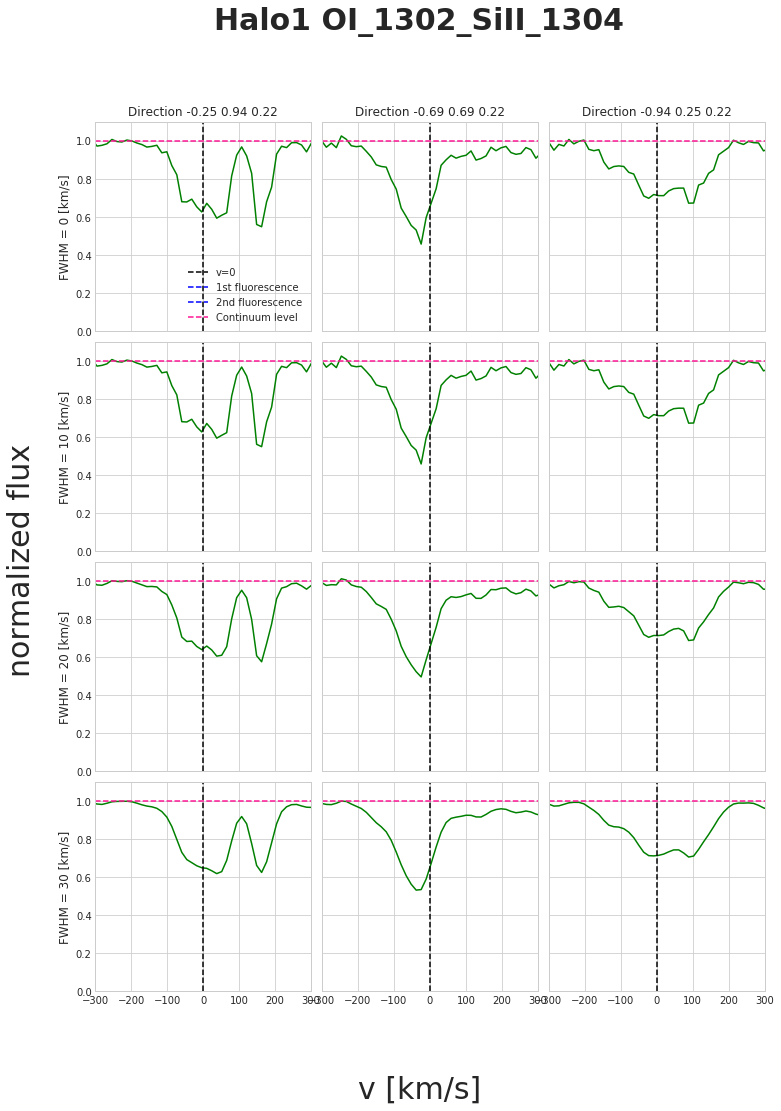

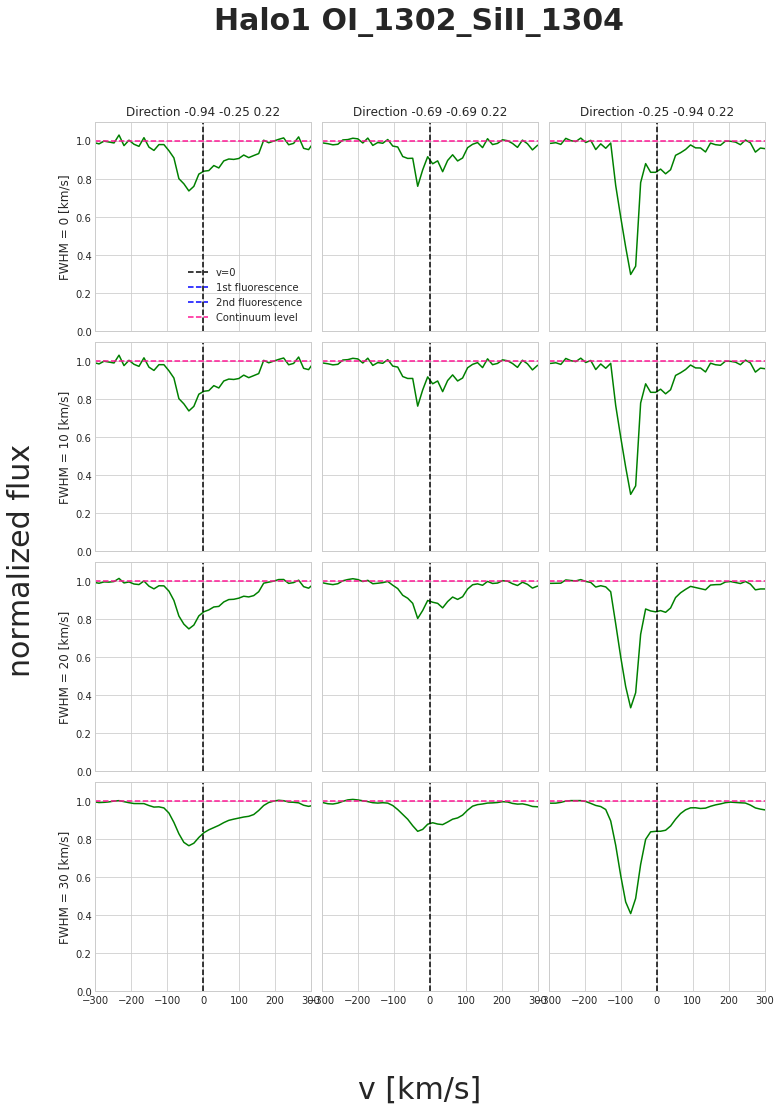

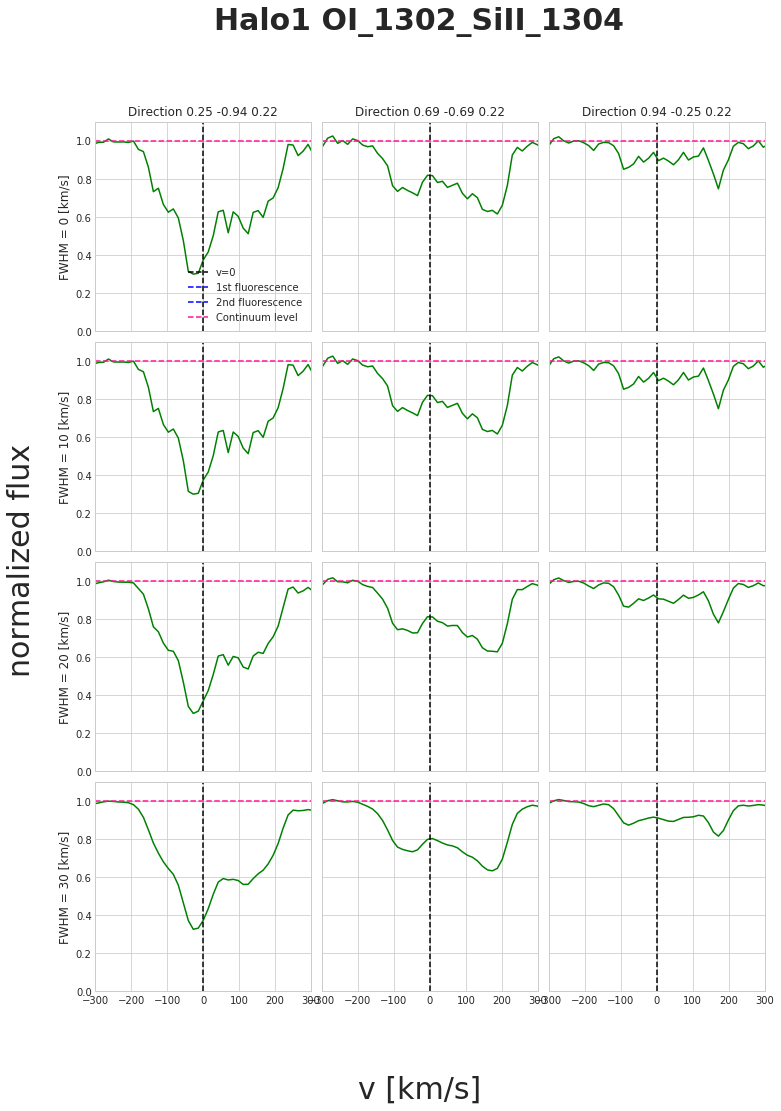

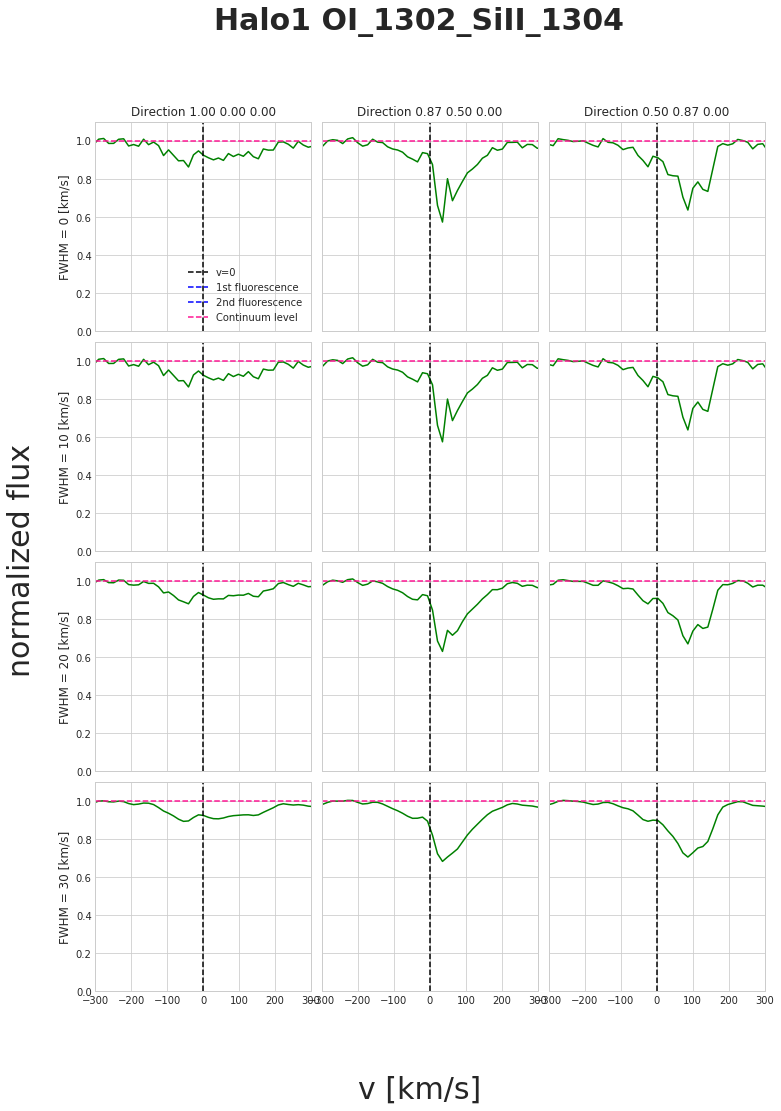

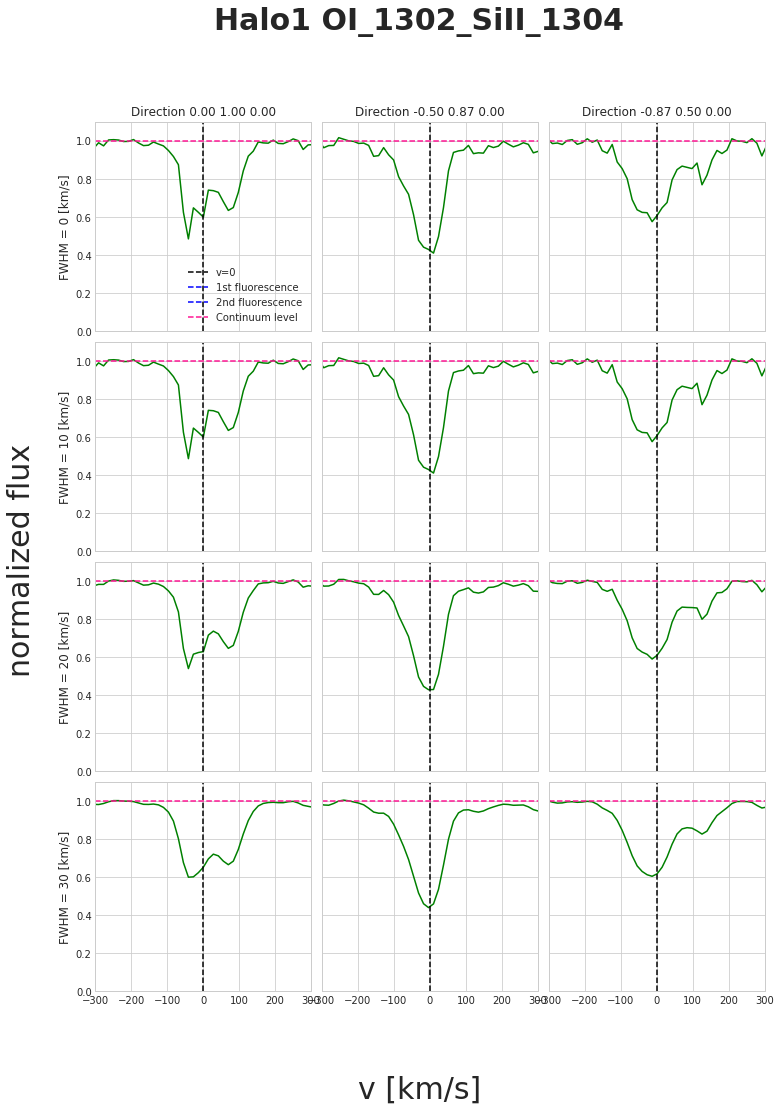

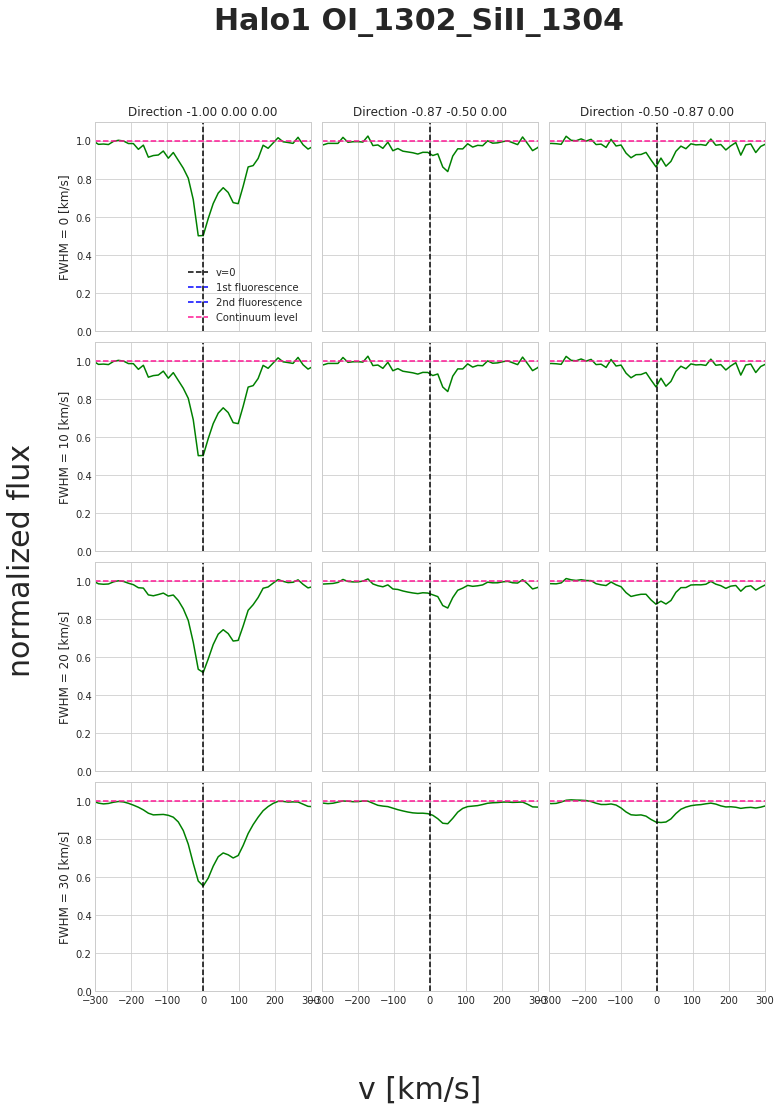

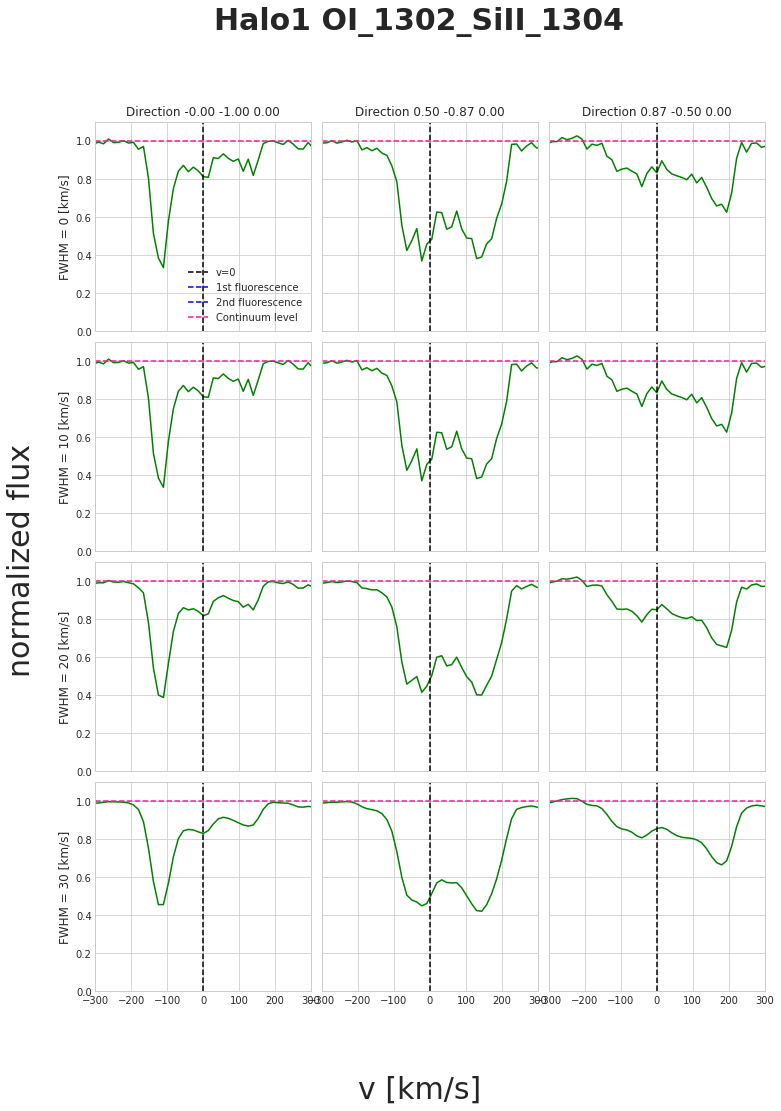

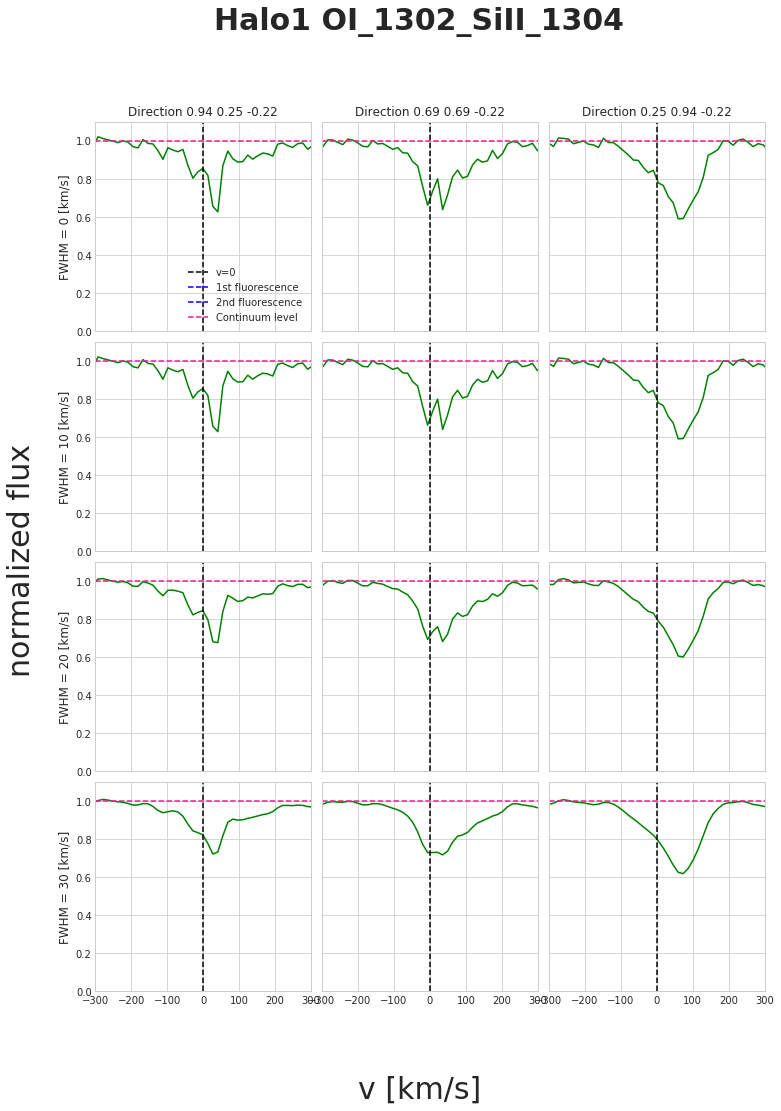

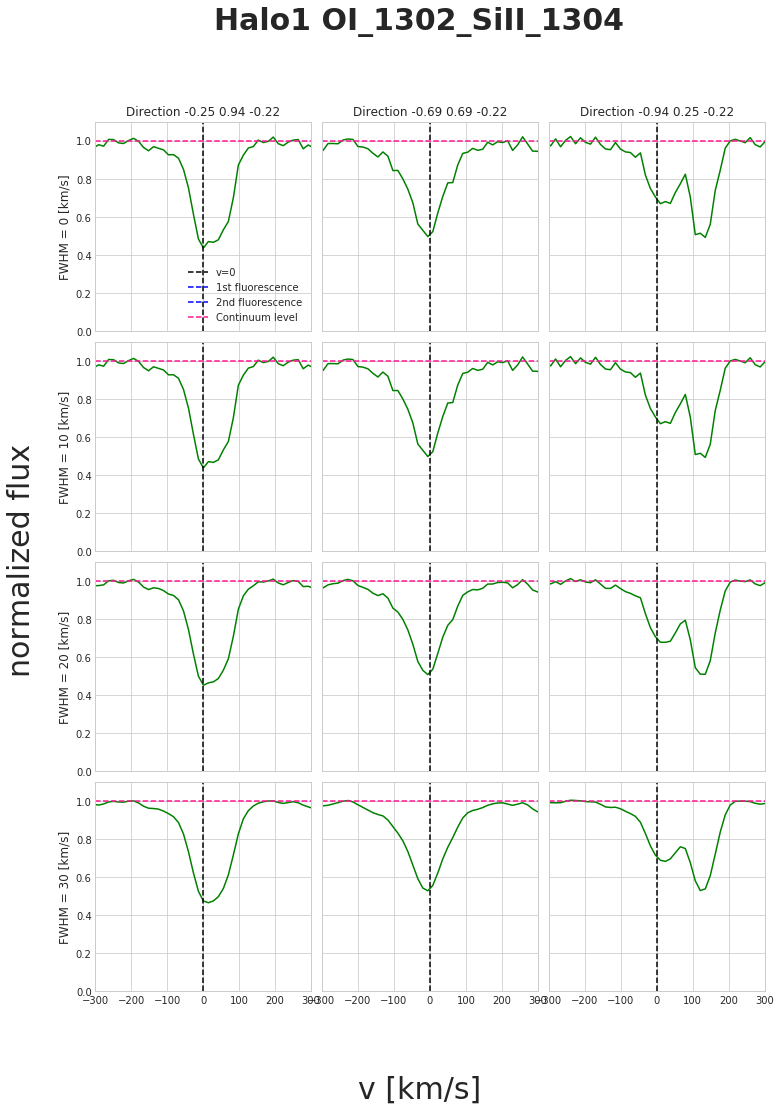

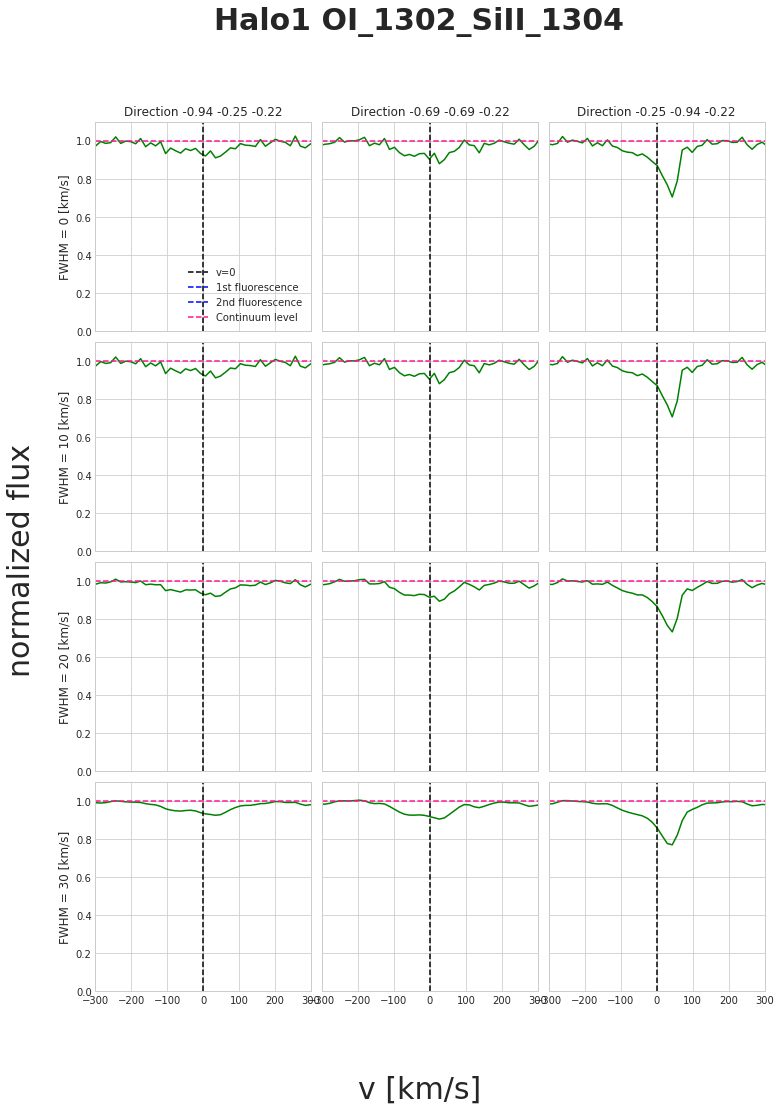

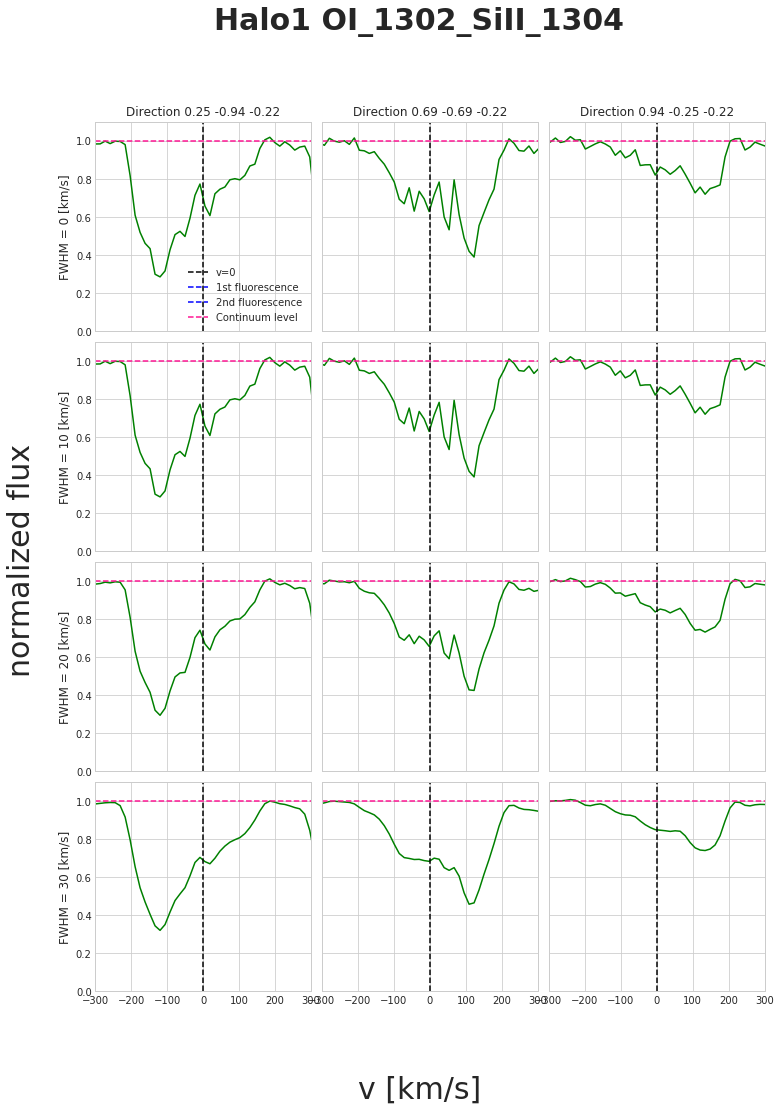

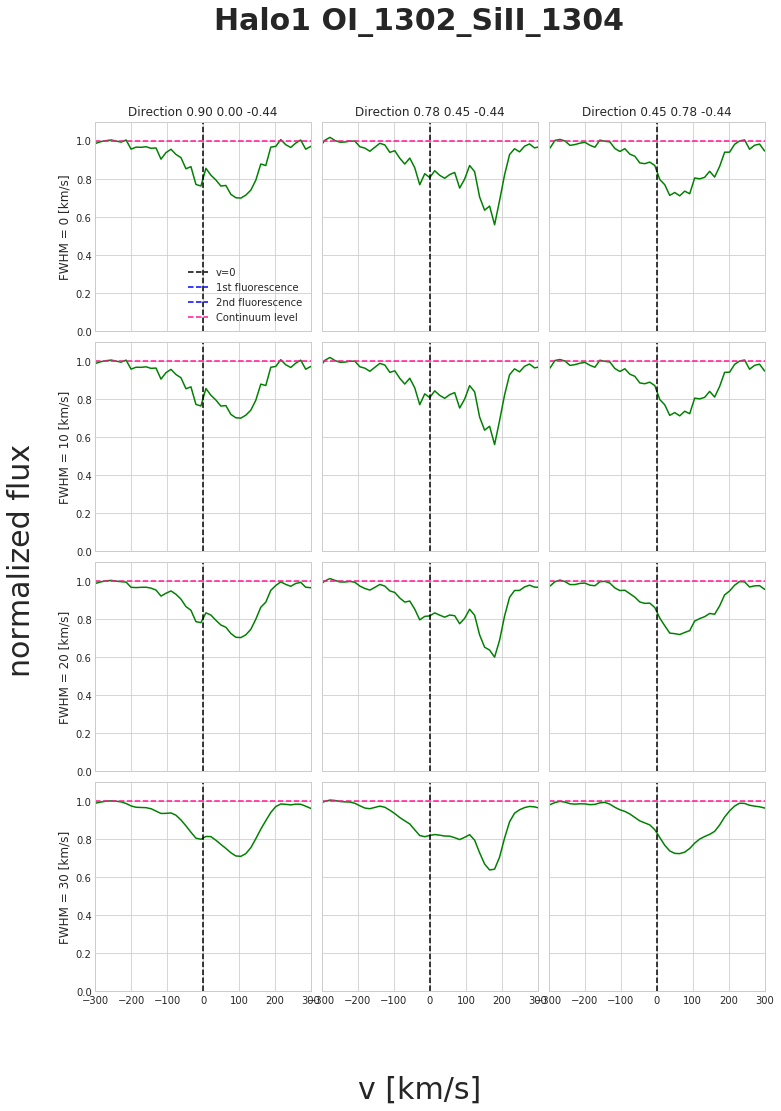

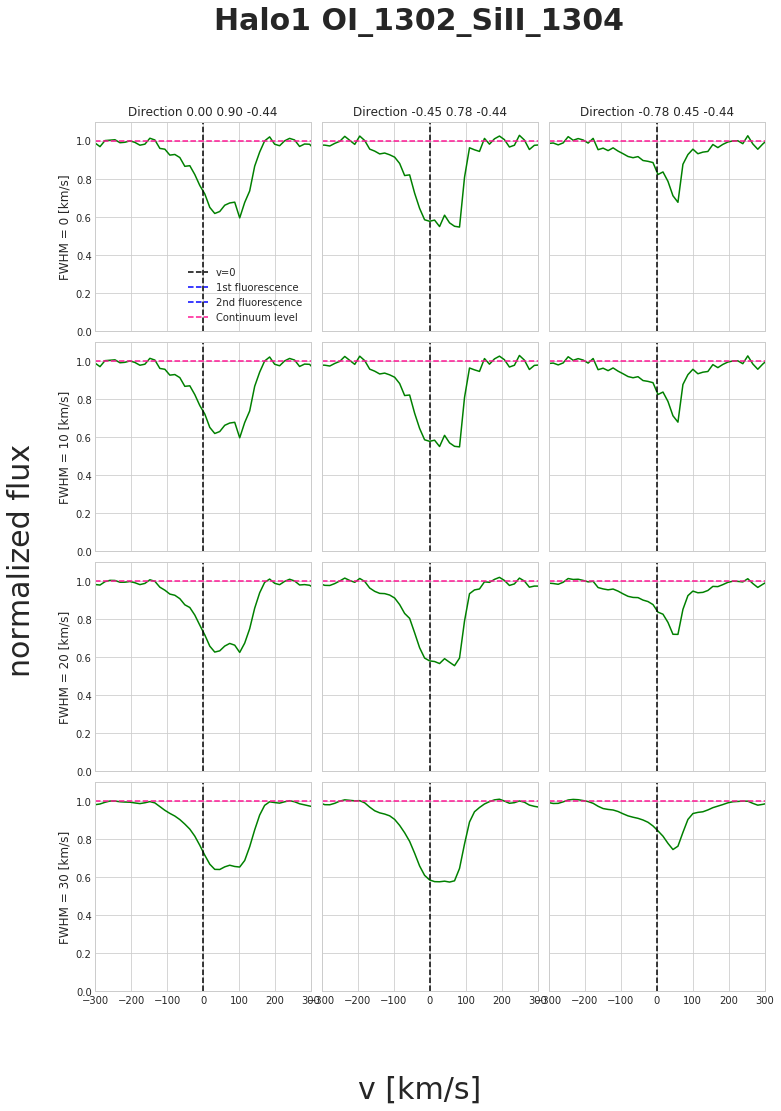

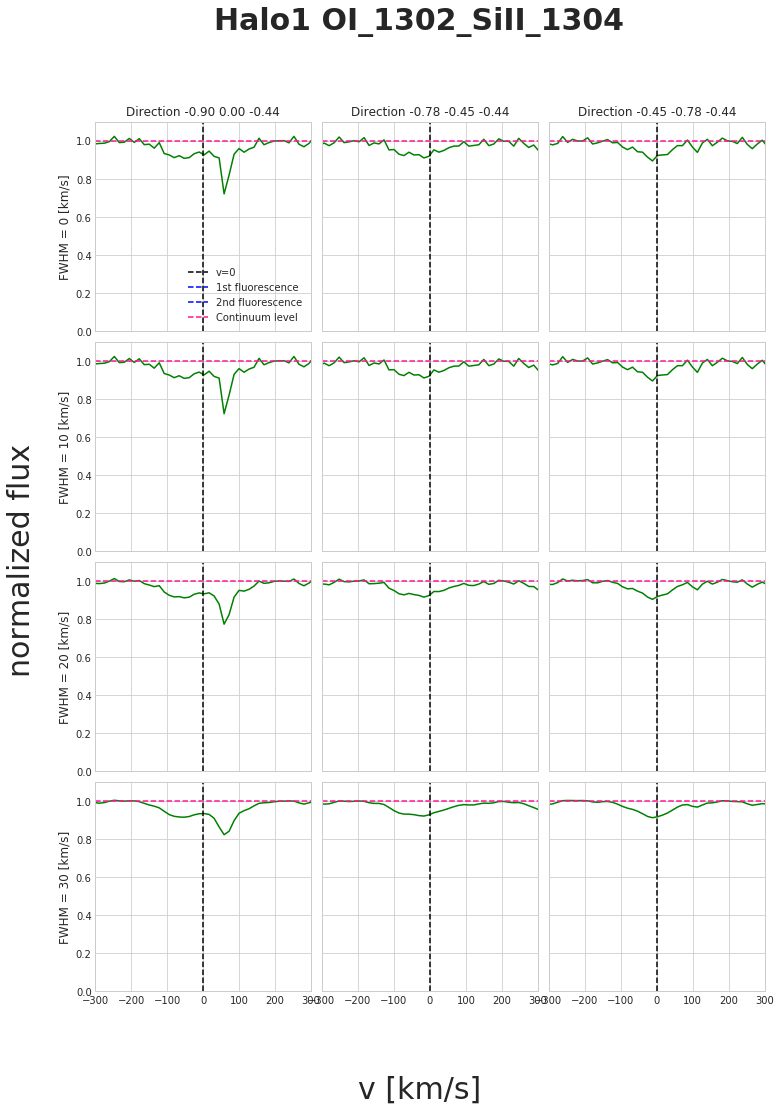

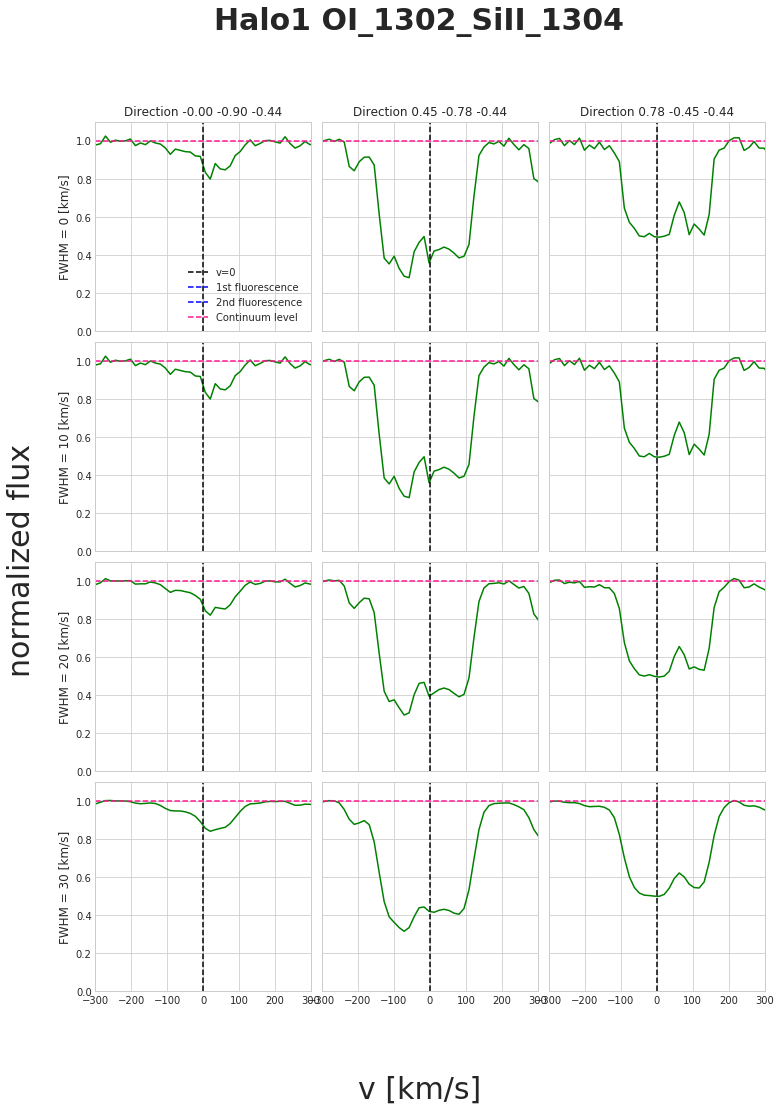

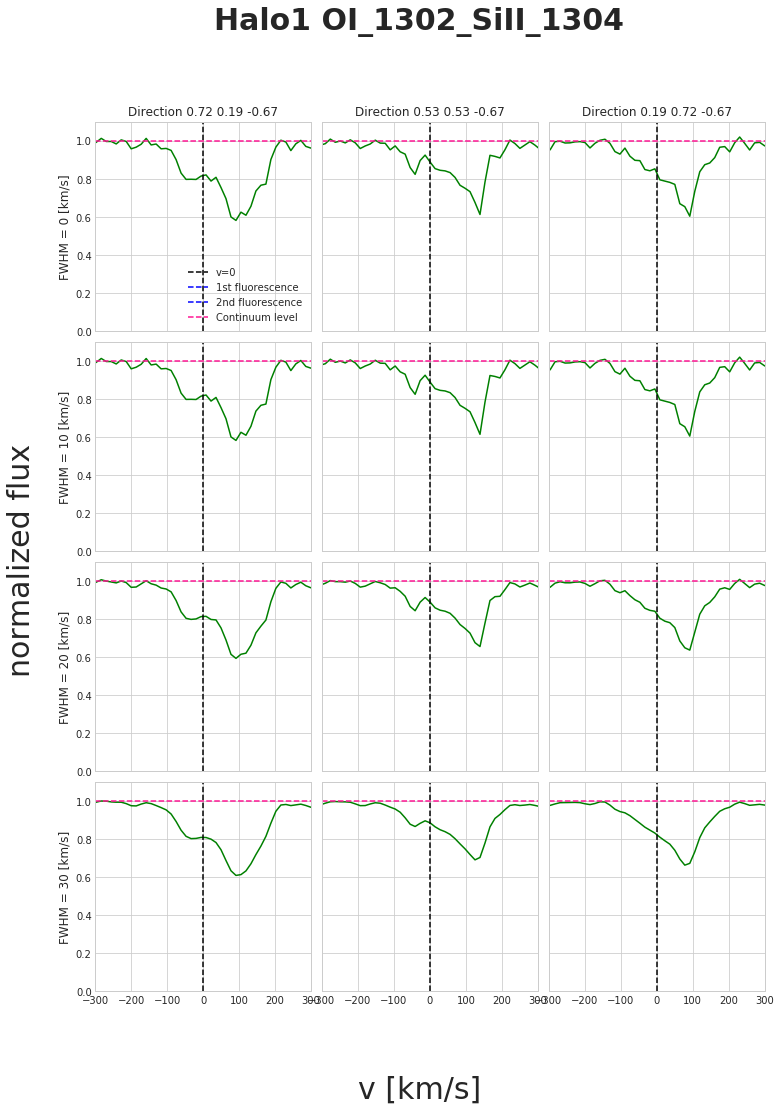

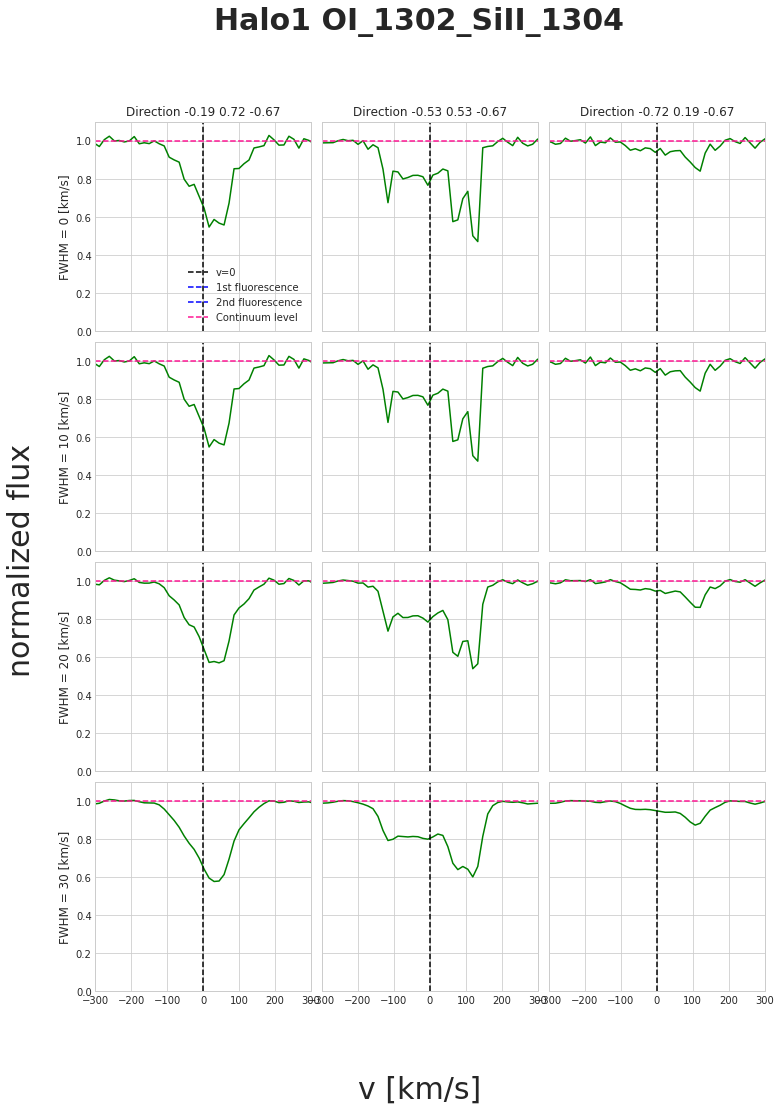

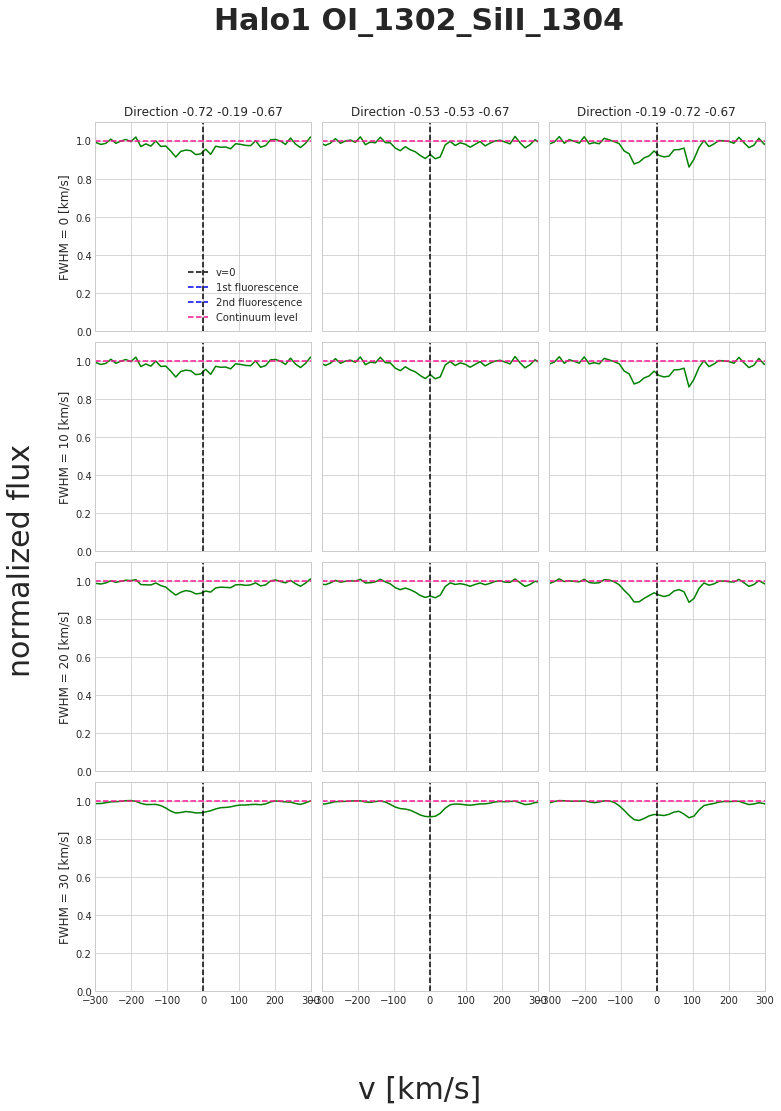

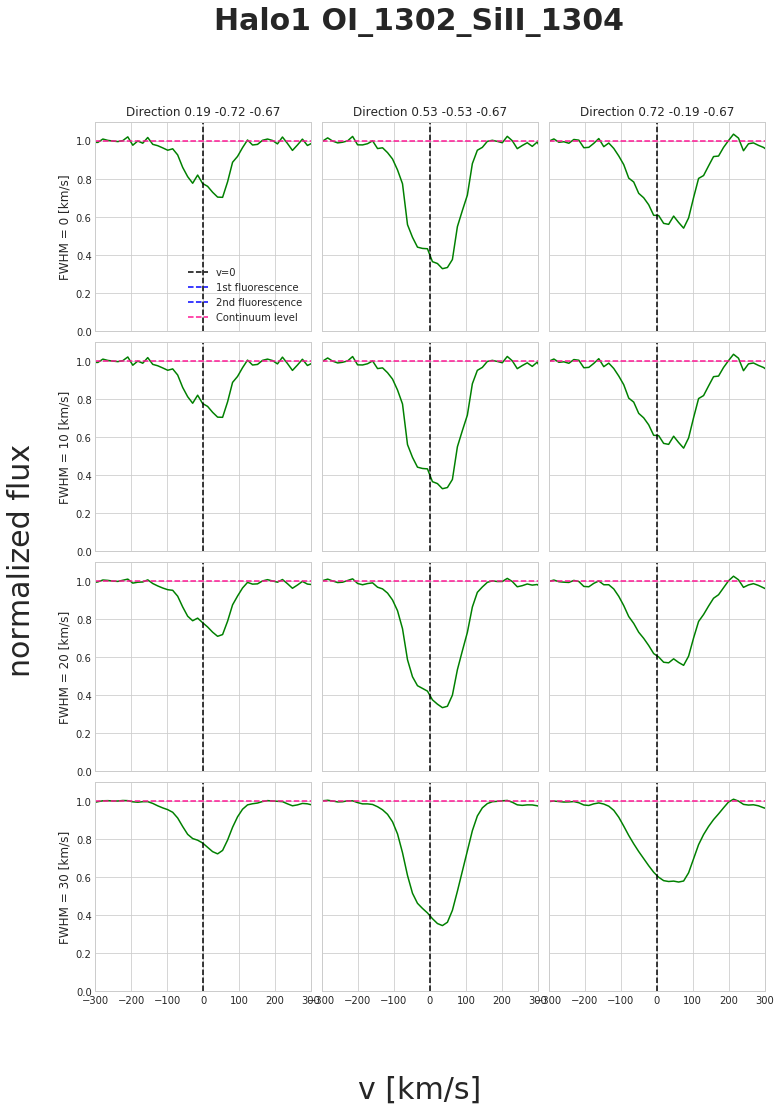

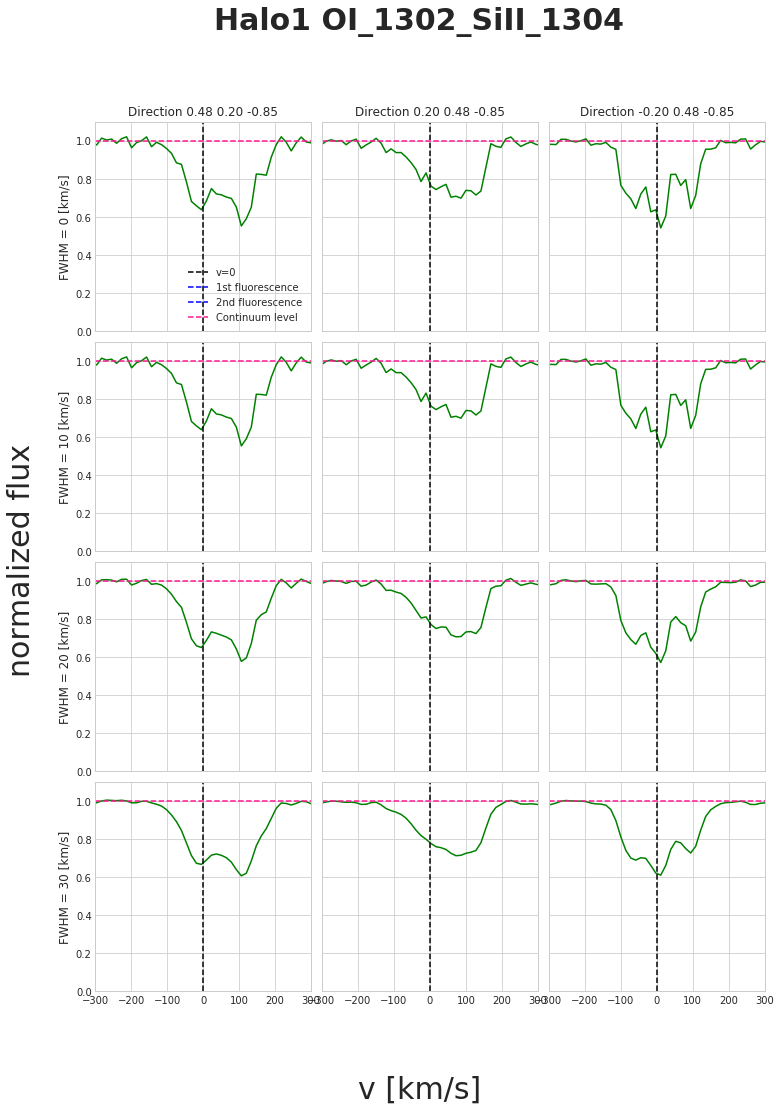

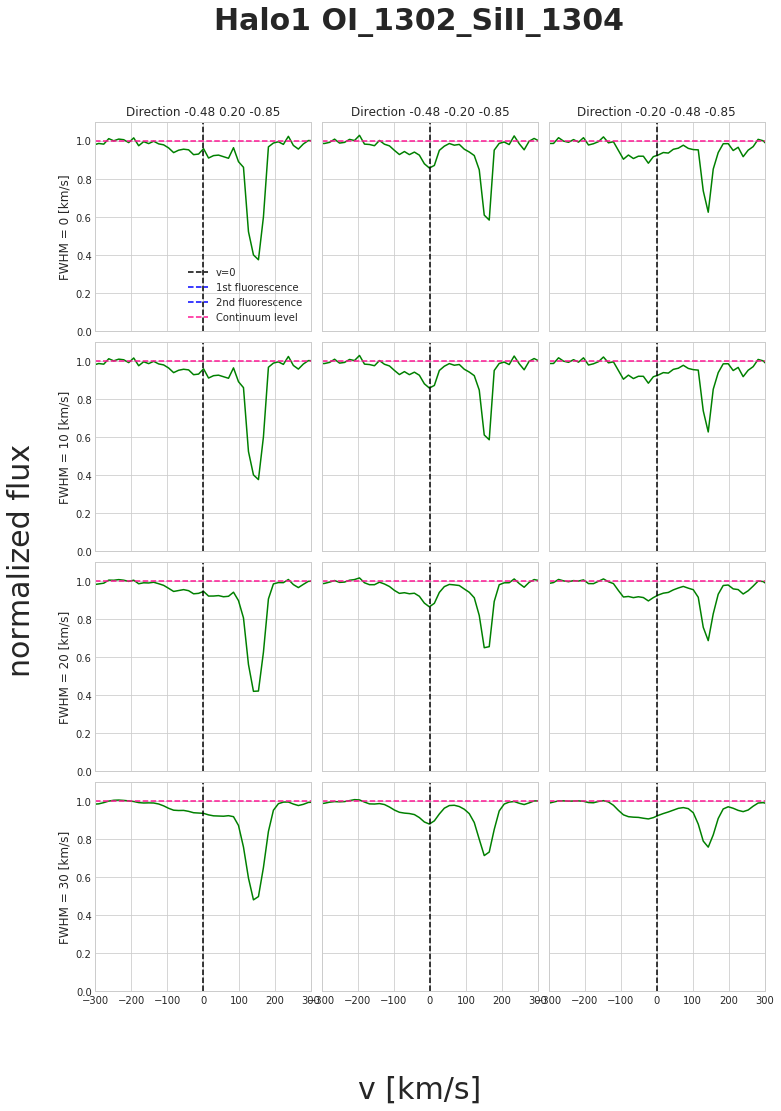

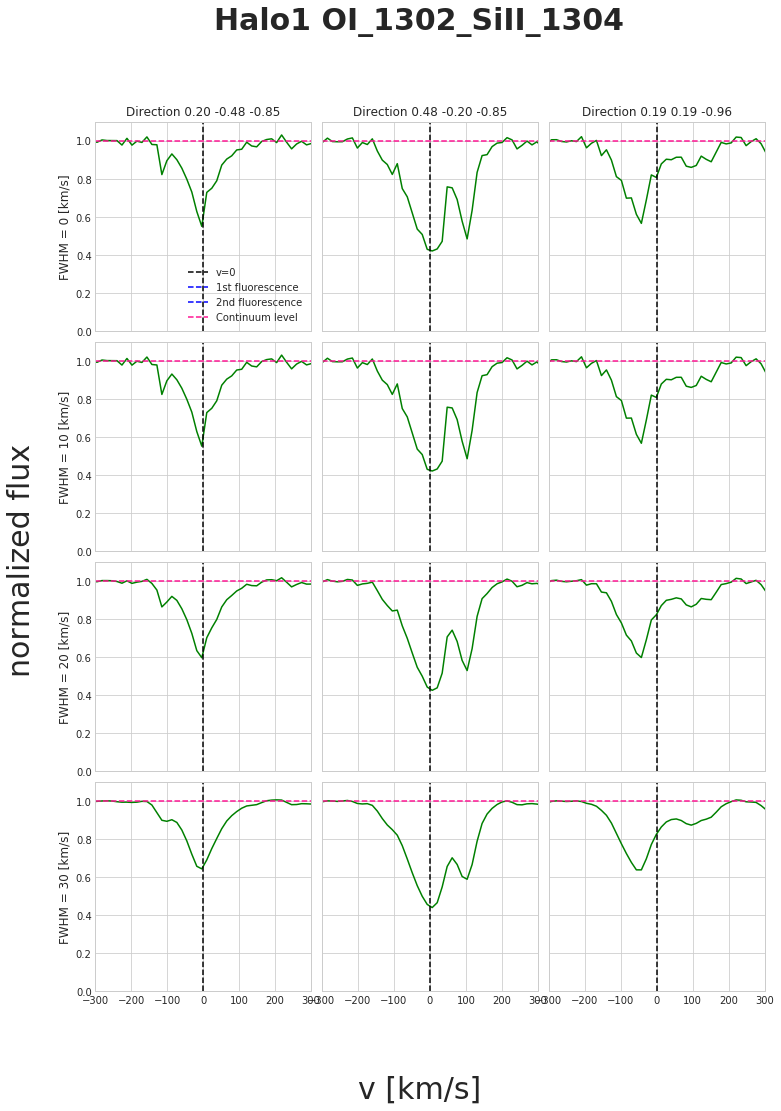

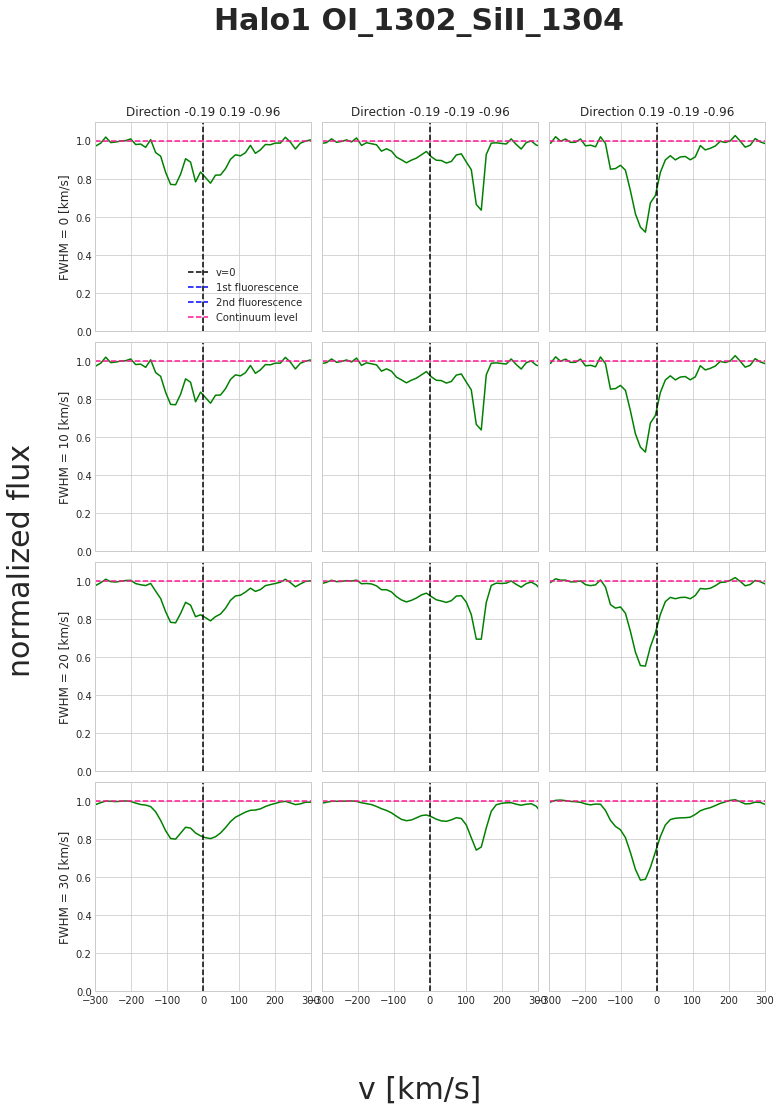

In [6]:
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
nn=3
npages=nvec//nn
rows = ['FWHM = %i [km/s]'%j for j in [0]+FWHM]
with PdfPages('plots_Halo1_OI_1302_SiII_1304.pdf') as pdf:
    
    for m in range(npages):
        if(dark):
            plt.style.use('dark_background')
        else :
            plt.style.use('seaborn-whitegrid')

        fig, ax = plt.subplots(4, 3, sharex=True, sharey=True, figsize=fig_size, gridspec_kw = {'wspace':0.05, 'hspace':0.05})
        fig.suptitle('Halo1 OI_1302_SiII_1304', size = 30, weight='bold')
        
        if(v_plot):
            fig.text(0.5, 0.04, 'v [km/s]', va='center', ha='center', fontsize=30)
        else :
            fig.text(0.5, 0.04, r'$\lambda \, $ [A]', va='center', ha='center', fontsize=30)
        if(normalized):
            fig.text(0.04, 0.5, 'normalized flux', va='center', ha='center', rotation='vertical', fontsize=30)
        else :
            fig.text(0.04, 0.5, 'luminosity [erg/s/A]', va='center', ha='center', rotation='vertical', fontsize=30)
        
        cols = ['Direction %04.2f %04.2f %04.2f'%(k[i+m*nn][0],k[i+m*nn][1],k[i+m*nn][2]) for i in range(nn)]


        for i in range(0,nn):

            kobs = np.array([k[i+m*nn][0],k[i+m*nn][1],k[i+m*nn][2]])
            a = []
            for j in range(1,noutput+1):
                a.append(po.mockobs('.', 'output_result.%i.out'%(j), 'output_%i.out'%j, \
                                    load_spectrum=True, load_image=False, load_cube=False, idirection=i+1+m*nn))

            spec_peeloff = 0
            nPhotons = 0
            for j in range(0,noutput):
                spec_peeloff += a[j].spec*a[j].nPhotons
                nPhotons += a[j].nPhotons
            spec_peeloff = spec_peeloff[1:-1]/nPhotons

            l_peeloff = np.linspace(a[0].spec_lmin,a[0].spec_lmax,num=a[0].spec_npix)[1:-1]  # [A]
            v_peeloff = c.c_cgs*(l_peeloff-line)/line*1e-5
            v_peeloff = v_peeloff + np.dot(kobs,v_cm)
            if(normalized): spec_peeloff = spec_peeloff/np.average(spec_peeloff[np.where((v_peeloff>-900) & (v_peeloff<-700))])
             
            for isig in range(len(FWHM)+1):
                if(isig>0):
                    gauss_kernel = Gaussian1DKernel(FWHM[isig-1]/(v_peeloff[1]-v_peeloff[0])/2.35)
                    spec_peeloff = convolve(spec_peeloff,gauss_kernel)

                if v_plot:
                    ax[isig,z[isig+i*(nn+1)]].plot(v_peeloff,spec_peeloff, color)
                    ax[isig,z[isig+i*(nn+1)]].set_xlim(-900, 1500)
                    if((i==0) & (isig==0)):
                        ax[isig,z[isig+i*(nn+1)]].axvline(0,color='black',linestyle='--', label='v=0')
                        ax[isig,z[isig+i*(nn+1)]].axvline((1304.858-line)/line*c.c_cgs*1e-5,color='blue',linestyle='--', label='1st fluorescence')
                        ax[isig,z[isig+i*(nn+1)]].axvline((1306.029-line)/line*c.c_cgs*1e-5,color='blue',linestyle='--', label='2nd fluorescence')
                    else:
                        ax[isig,z[isig+i*(nn+1)]].axvline(0,color='black',linestyle='--')
                        ax[isig,z[isig+i*(nn+1)]].axvline((1304.858-line)/line*c.c_cgs*1e-5,color='blue',linestyle='--')
                        ax[isig,z[isig+i*(nn+1)]].axvline((1306.029-line)/line*c.c_cgs*1e-5,color='blue',linestyle='--')
                else:
                    ax[isig,z[isig+i*(nn+1)]].plot(l_peeloff,spec_peeloff, color)
                    ax[isig,z[isig+i*(nn+1)]].set_xlim(1300.5, 1311.5)
                    if((i==0) & (isig==0)):
                        ax[isig,z[isig+i*(nn+1)]].axvline(line,color='black',linestyle='--', label='OI 1302 line center')
                        ax[isig,z[isig+i*(nn+1)]].axvline(1304.858,color='blue',linestyle='--', label='OI 1st fluorescence')
                        ax[isig,z[isig+i*(nn+1)]].axvline(1306.029,color='blue',linestyle='--', label='OI 2nd fluorescence')
                        ax[isig,z[isig+i*(nn+1)]].axvline(1304.37,color='black',linestyle='--', label='SiII 1304 line center')
                        ax[isig,z[isig+i*(nn+1)]].axvline(1309.27,color='blue',linestyle='--', label='SiII fluorescence')
                    else:
                        ax[isig,z[isig+i*(nn+1)]].axvline(line,color='black',linestyle='--')
                        ax[isig,z[isig+i*(nn+1)]].axvline(1304.858,color='blue',linestyle='--')
                        ax[isig,z[isig+i*(nn+1)]].axvline(1306.029,color='blue',linestyle='--')
                        ax[isig,z[isig+i*(nn+1)]].axvline(1304.37,color='black',linestyle='--')
                        ax[isig,z[isig+i*(nn+1)]].axvline(1309.27,color='blue',linestyle='--')
                ax[isig,z[isig+i*(nn+1)]].set_xlim(-300, 300)
                if(normalized):
                    ax[isig,z[isig+i*(nn+1)]].set_ylim(0.0, 1.1)
                    if((i==0) & (isig==0)):
                        ax[isig,z[isig+i*(nn+1)]].axhline(1,color='deeppink',linestyle='--', label='Continuum level')
                    else:
                        ax[isig,z[isig+i*(nn+1)]].axhline(1,color='deeppink',linestyle='--')
                else:
                    if((i==0) & (isig==0)):
                        ax[isig,z[isig+i*(nn+1)]].axhline(np.average(spec_peeloff[np.where((v_peeloff>-900) \
                                        & (v_peeloff<-700))]),color='deeppink',linestyle='--', label='Continuum level')
                    else:
                        ax[isig,z[isig+i*(nn+1)]].axhline(np.average(spec_peeloff[np.where((v_peeloff>-900) \
                                        & (v_peeloff<-700))]),color='deeppink',linestyle='--')

                if((i==0) & (isig==0)):
                    ax[isig,z[isig+i*(nn+1)]].legend(loc='lower right')
                
        for axes, row in zip(ax[:,0], rows):
            axes.set_ylabel(row, rotation='vertical', size='large')
        for axes, col in zip(ax[0], cols):
            axes.set_title(col)

        pdf.savefig()  # saves the current figure into a pdf page     
    

In [136]:
print(plt.style.available)

['Solarize_Light2', '_classic_test', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'tableau-colorblind10']
